# Calculate SWE Using Nearest Within-Cluster Station SNV

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
from rasterio.merge import merge

### Read in data, reproject to utm, and reinstate multiindexes:

In [2]:
huc10 = gpd.read_file('../../data/huc10_clusters_loc.geojson')

In [4]:
huc10['nearest_loc'] = huc10['nearest_loc'].values.astype('str')
huc10['huc10'] = huc10['huc10'].values.astype('int')

In [3]:
swe = xr.open_dataset('../../data/swe_reanalysis_ucrb.nc')

In [4]:
swe.rio.crs

CRS.from_epsg(4326)

In [4]:
swe_utm = swe.rio.reproject('epsg:32611')

In [5]:
#ds.rio.set_spatial_dims('y','x',inplace=True)
swe_utm = swe_utm.rio.set_spatial_dims('y','x',inplace=True)

In [7]:
swe_calc = xr.open_dataset('../../data/swe_calculated_snv.nc')

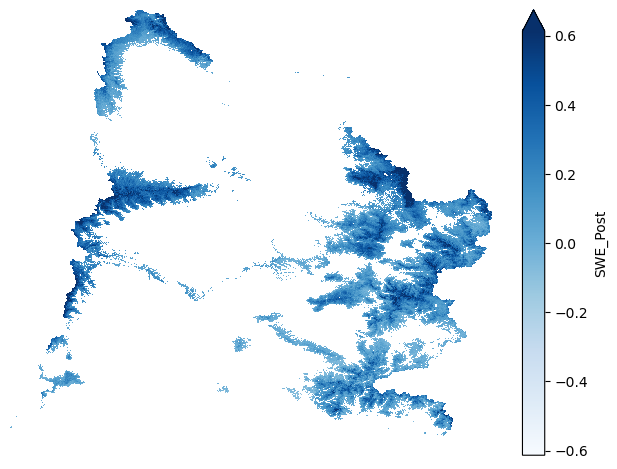

In [6]:
fig, ax = plt.subplots()
swe_calc.SWE_Post[0].plot(cmap='Blues',robust=True)
plt.axis('off')
plt.title('')
plt.tight_layout()
plt.savefig('swe_plot.jpeg',dpi=500)

In [8]:
swe_dif = xr.open_dataset('../../data/swe_difference_snv_reanalysis.nc')

In [13]:
np.abs(swe_dif.SWE_Post).mean()

<xarray.DataArray 'SWE_Post' ()> Size: 4B
array(0.10585053, dtype=float32)

In [12]:
swe_dif.SWE_Post.std()

<xarray.DataArray 'SWE_Post' ()> Size: 4B
array(0.14315002, dtype=float32)

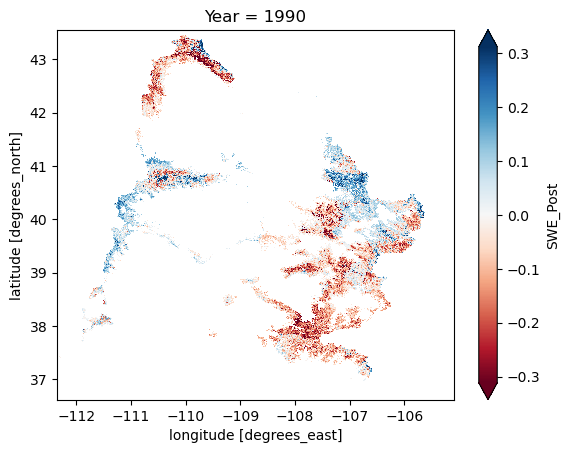

In [16]:
swe_dif.SWE_Post[0].plot(robust=True, cmap='RdBu')

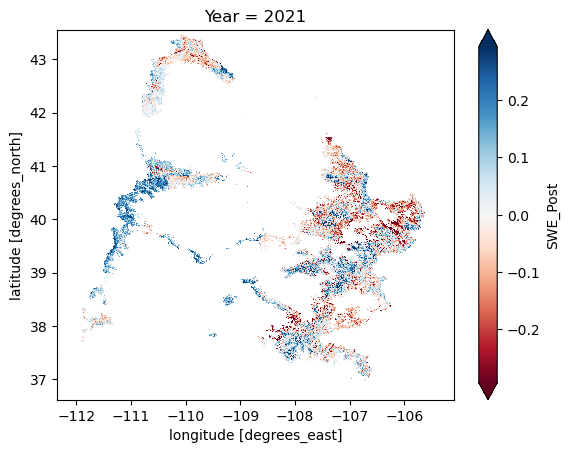

In [17]:
swe_dif.SWE_Post[31].plot(robust=True, cmap='RdBu')

In [8]:
stations = gpd.read_file('../data/snv_temp_precip_gdf.geojson')

In [9]:
# from https://stackoverflow.com/questions/38901145/create-a-dataframe-with-a-multiindex
idx = pd.MultiIndex.from_product([stations['station'].unique(),
                                  stations['year'].unique()],
                                 names=['station', 'year'])
col = ['station_snv']
df = pd.DataFrame(stations['station_n'].values, idx, col)
df['station_swe'] = stations['station_swe'].values

station_gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(stations.geometry.x, stations.geometry.y), crs='epsg:4326')

In [10]:
len(station_gdf.index.get_level_values(0).unique())

445

<Axes: title={'center': 'Year = 1990, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

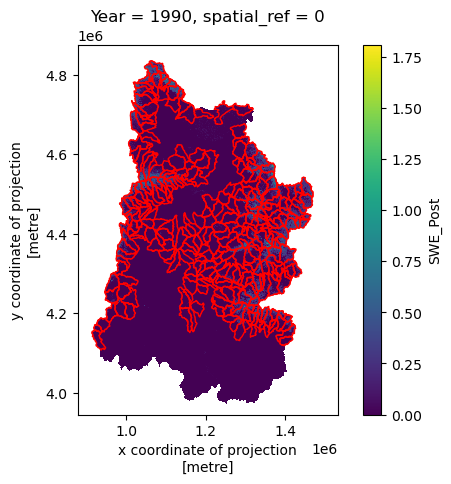

In [9]:
fig, ax = plt.subplots()
swe_utm['SWE_Post'].isel(Year=0).plot(ax=ax)
huc10.plot(ax=ax, facecolor='none',edgecolor='red')

In [60]:
huc10[0:1].geometry

0    POLYGON ((1379613.443 4527645.760, 1380122.341...
Name: geometry, dtype: geometry

### Test for one watershed:

In [104]:
temp_swe = swe_utm.rio.clip(huc10[0:1].geometry)

<Axes: title={'center': 'Year = 1990, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

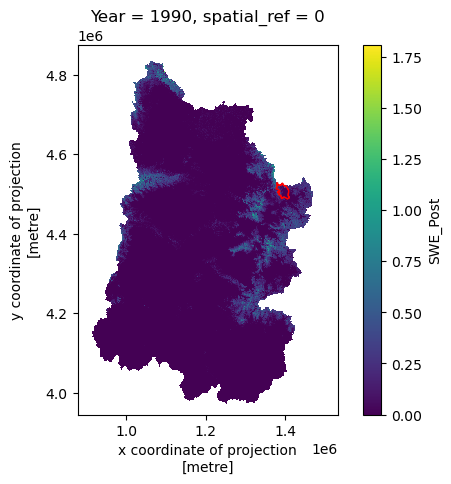

In [62]:
fig, ax = plt.subplots()
swe_utm.SWE_Post[0].plot(ax=ax)
huc10[0:1].plot(ax=ax,facecolor='none',edgecolor='red')


<Axes: title={'center': 'Year = 1990, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

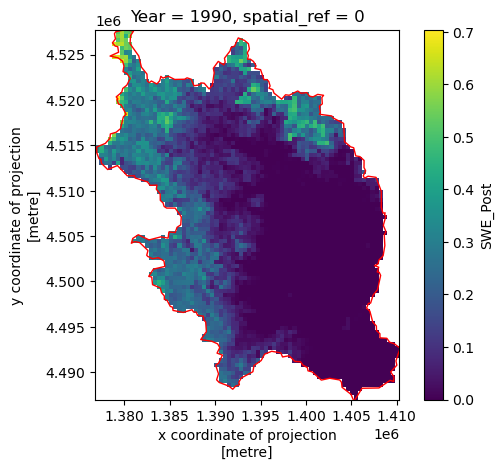

In [63]:
fig, ax = plt.subplots()
temp_swe.SWE_Post[0].plot()
huc10[0:1].plot(ax=ax,facecolor='none',edgecolor='red')

In [105]:
#site = huc10.loc[0,'nearest_loc']
swe_calc_test = station_gdf.loc[pd.IndexSlice[huc10.loc[0,'nearest_loc'],1990],'station_snv'] * temp_swe.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(temp_swe.SWE_Post.mean(dim='Year')>0.1) + temp_swe.SWE_Post.mean(dim='Year').where(temp_swe.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<Axes: title={'center': 'Year = 1990, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

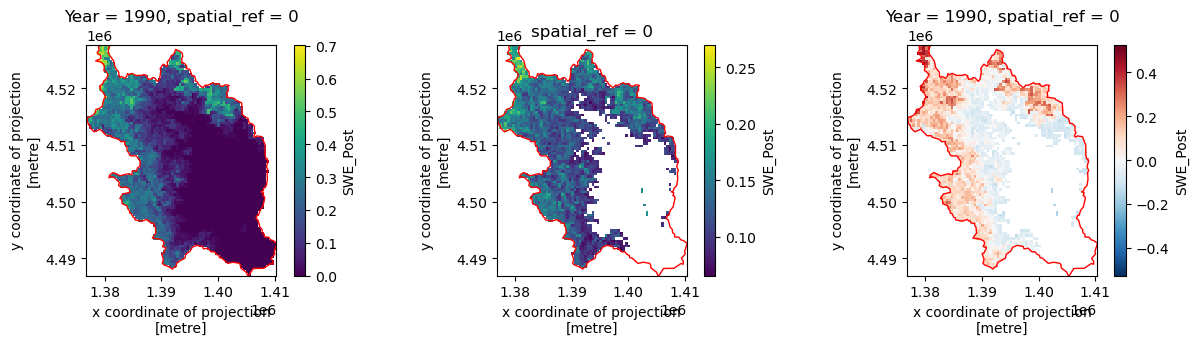

In [100]:
fig, ax = plt.subplots(1,3,figsize=(15,3))

temp_swe.SWE_Post[0].plot(ax=ax[0])
huc10[0:1].plot(ax=ax[0],facecolor='none',edgecolor='red')

swe_calc_test.plot(ax=ax[1])
huc10[0:1].plot(ax=ax[1],facecolor='none',edgecolor='red')

(temp_swe.SWE_Post[0] - swe_calc_test).plot(ax=ax[2])
huc10[0:1].plot(ax=ax[2],facecolor='none',edgecolor='red')

In [11]:
huc10['huc10'] = huc10['huc10'].astype('int')

In [12]:
huc10_32613 = huc10.to_crs('epsg:32613')

### Test for a second watershed:

In [108]:
temp_swe2 = swe_utm.rio.clip(huc10[1:2].geometry)

In [109]:
swe_calc_test2 = station_gdf.loc[pd.IndexSlice[huc10.loc[1,'nearest_loc'],1990],'station_snv'] * temp_swe2.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(temp_swe2.SWE_Post.mean(dim='Year')>0.1) + temp_swe2.SWE_Post.mean(dim='Year').where(temp_swe2.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


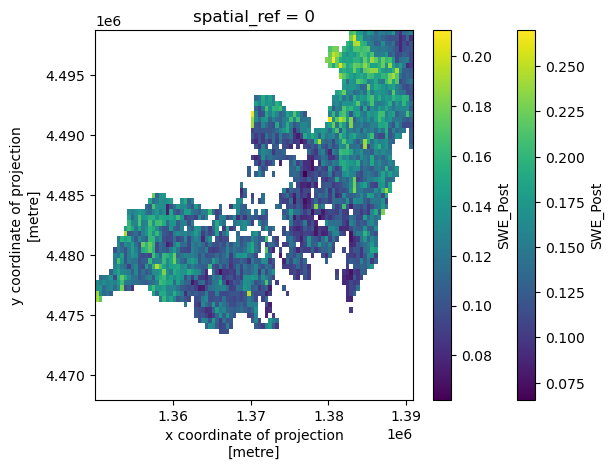

In [111]:
fig, ax = plt.subplots()
swe_calc.plot(ax=ax)
swe_calc_test2.plot(ax=ax)

### Plot the two together:

(4465000.0, 4530000.0)

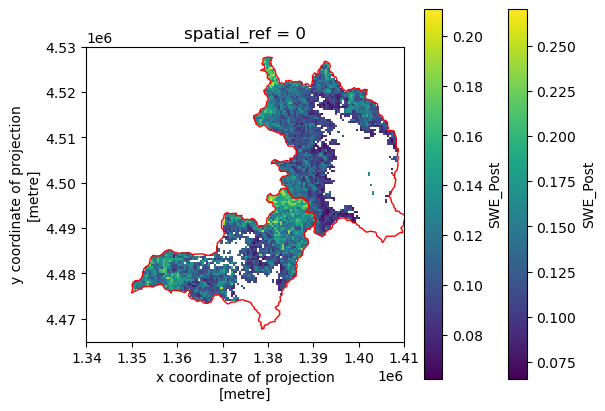

In [239]:
fig, ax = plt.subplots()
swe_calc.plot(ax=ax)
swe_calc_test2.plot(ax=ax)
huc10[0:3].plot(ax=ax, facecolor='none', edgecolor='red')

plt.xlim(1340000, 1410000)
plt.ylim(4465000, 4530000)

### Combine watersheds into one netcdf:

In [248]:
raster1_aligned, raster2_aligned = xr.align(swe_calc, swe_calc_test2, join='outer')
# Example: Taking the mean where both rasters overlap
combined_data = xr.where(raster1_aligned.isnull(), raster2_aligned, raster1_aligned)
combined_data = xr.where(raster2_aligned.isnull(), raster1_aligned, combined_data)
combined_data = xr.where((~raster1_aligned.isnull()) & (~raster2_aligned.isnull()),
                         (raster1_aligned + raster2_aligned) / 2, combined_data)

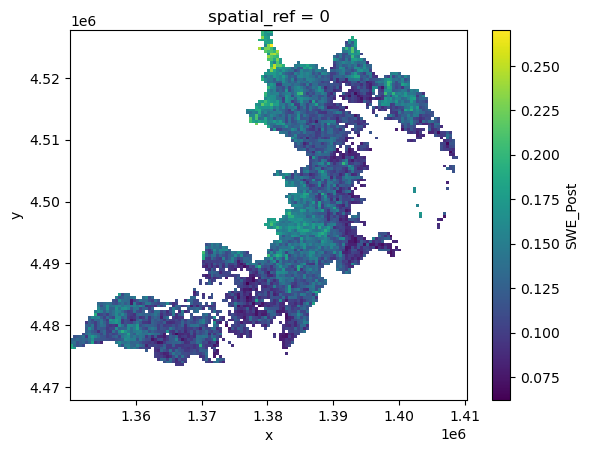

In [250]:
combined_data.plot()

### Create a multiindex dataframe to hold the SWE data summed over the watershed:

In [21]:
huc10.set_index('huc10',inplace=True)

In [133]:
huc10

huc2  areaacres  areasqkm states                             name  \
huc10                                                                           
1401000107    14  188277.05    761.93     CO                      Muddy Creek   
1401000110    14  128574.43    520.32     CO                       Rock Creek   
1401000302    14  166516.89    673.87     CO                Upper Eagle River   
1404010108    14  100005.00    404.71     WY                      Muddy Creek   
1406000902    14  216409.64    875.78     UT                 Cottonwood Creek   
...          ...        ...       ...    ...                              ...   
1405000502    14  115375.88    466.91     CO           South Fork White River   
1408010105    14  118666.73    480.23     NM                    Amargo Canyon   
1404010101    14  134201.76    543.10     WY         Roaring Fork-Green River   
1405000307    14  189709.79    767.73  CO,WY  Willow Creek-Little Snake River   
1404010610    14  184563.80    746.90  CO,UT          Conway Draw-Green River   

            cluster  area_cluster  nearest_loc  \
huc10                                            
1401000107      1.0  6.118408e+08  408_CO_SNTL   
1401000110      1.0  4.785160e+08  607_CO_SNTL   
1401000302      1.0  6.872709e+08  842_CO_SNTL   
1404010108      1.0  9.027048e+07  509_WY_SNTL   
1406000902      1.0  3.123196e+08  329_UT_SNTL   
...             ...           ...          ...   
1405000502      1.0  4.738813e+08  378_CO_SNTL   
1408010105      0.0  4.040915e+07  394_NM_SNTL   
1404010101      2.0  4.828590e+08  506_WY_SNTL   
1405000307      1.0  2.829969e+08  317_WY_SNTL   
1404010610      1.0  2.409002e+07  528_UT_SNTL   

                                                     geometry  
huc10                                                          
1401000107  POLYGON ((1379613.443 4527645.760, 1380122.341...  
1401000110  POLYGON ((1384030.472 4498732.289, 1384363.182...  
1401000302  POLYGON ((1411742.711 4439561.319, 1412013.602...  
1404010108  POLYGON ((1053045.537 4758509.975, 1053548.979...  
1406000902  POLYGON ((989137.830 4387368.433, 989645.145 4...  
...                                                       ...  
1405000502  POLYGON ((1303424.592 4468466.426, 1304108.376...  
1408010105  POLYGON ((1402308.681 4141290.135, 1402864.392...  
1404010101  POLYGON ((1063496.052 4834431.345, 1063909.172...  
1405000307  POLYGON ((1300062.091 4601048.944, 1300853.574...  
1404010610  POLYGON ((1181651.215 4560420.096, 1183394.402...  

[302 rows x 9 columns]

In [23]:
huc10.index.dtype

dtype('int64')

In [24]:
idx = pd.MultiIndex.from_product([huc10.index.unique(),
                                  stations['year'].unique()],
                                 names=['huc10_id', 'year'])

col = ['swe_snv_sum','swe_reanalysis_sum','snv_snotel']
huc10_swe = pd.DataFrame(np.nan, idx, col)
#huc10_swe = huc10_swe.sort_index()
#huc10_swe['station_swe'] = stations['station_swe'].values

#huc10_swe = gpd.GeoDataFrame(huc10_swe)
#huc10_swe = huc10_swe.set_geometry(huc10.geometry, crs='epsg:32611')

In [13]:
huc10_swe

swe_snv_sum  swe_reanalysis_sum  snv_snotel
huc10_id   year                                             
1401000101 1990          NaN                 NaN         NaN
           1991          NaN                 NaN         NaN
           1992          NaN                 NaN         NaN
           1993          NaN                 NaN         NaN
           1994          NaN                 NaN         NaN
...                      ...                 ...         ...
1408020301 2017          NaN                 NaN         NaN
           2018          NaN                 NaN         NaN
           2019          NaN                 NaN         NaN
           2020          NaN                 NaN         NaN
           2021          NaN                 NaN         NaN

[9664 rows x 3 columns]

In [75]:
station_gdf

station_snv  station_swe                     geometry
station     year                                                       
301_CA_SNTL 1990    -0.492262     0.193040  POINT (-120.79192 41.23583)
            1991    -0.806681     0.142240  POINT (-120.79192 41.23583)
            1992    -1.639892     0.007620  POINT (-120.79192 41.23583)
            1993     0.938344     0.424180  POINT (-120.79192 41.23583)
            1994    -0.335053     0.218440  POINT (-120.79192 41.23583)
...                       ...          ...                          ...
BLD         2017     0.619445     1.033272  POINT (-120.03488 38.45126)
            2018    -0.806206     0.371856  POINT (-120.03488 38.45126)
            2019     0.501188     0.978408  POINT (-120.03488 38.45126)
            2020    -0.615681     0.460248  POINT (-120.03488 38.45126)
            2021    -0.418586     0.551688  POINT (-120.03488 38.45126)

[14240 rows x 3 columns]

In [25]:
id = 1401000107
huc10.loc[id]['nearest_loc']

'408_CO_SNTL'

In [77]:
huc10.loc[name]

huc2  areaacres  areasqkm states       huc10  cluster  \
name                                                                  
Beaver Creek    14   95041.88    384.62     WY  1404010102      2.0   
Beaver Creek    14   42594.65    172.37     CO  1408010113      0.0   

              area_cluster  nearest_loc  \
name                                      
Beaver Creek  3.184716e+08  597_WY_SNTL   
Beaver Creek  6.449373e+07  843_CO_SNTL   

                                                       geometry  
name                                                             
Beaver Creek  POLYGON ((1053646.519 4808201.291, 1053961.154...  
Beaver Creek  POLYGON ((1344787.084 4178788.935, 1345523.193...

In [15]:
huc10_swe.index.get_level_values(0).dtype

dtype('O')

In [27]:
for id, yr in zip(huc10_swe.index.get_level_values(0), huc10_swe.index.get_level_values(1)):
    huc10_swe.loc[id,yr]['snv_snotel'] = station_gdf.loc[huc10.loc[id]['nearest_loc'],yr]['station_snv']

### Test for one year over all watersheds:

In [29]:
huc10.loc[id]['nearest_loc']

'528_UT_SNTL'

In [28]:
huc10_swe

swe_snv_sum  swe_reanalysis_sum  snv_snotel
huc10_id   year                                             
1401000107 1990          NaN                 NaN    0.008432
           1991          NaN                 NaN    0.325875
           1992          NaN                 NaN   -0.864536
           1993          NaN                 NaN    0.246514
           1994          NaN                 NaN   -0.562965
...                      ...                 ...         ...
1404010610 2017          NaN                 NaN    0.504671
           2018          NaN                 NaN    0.137638
           2019          NaN                 NaN   -0.176963
           2020          NaN                 NaN    2.444706
           2021          NaN                 NaN    0.871705

[9664 rows x 3 columns]

In [30]:
station_gdf.loc['528_UT_SNTL',2021]

station_snv                                          0.871705
station_swe                                           0.21844
geometry       POINT (-110.18623352050781 40.921669006347656)
Name: (528_UT_SNTL, 2021), dtype: object

In [371]:
huc10.head()

huc2  areaacres  areasqkm states       huc10               name  cluster  \
0    14  188277.05    761.93     CO  1401000107        Muddy Creek      1.0   
1    14  128574.43    520.32     CO  1401000110         Rock Creek      1.0   
2    14  166516.89    673.87     CO  1401000302  Upper Eagle River      1.0   
3    14  100005.00    404.71     WY  1404010108        Muddy Creek      1.0   
4    14  216409.64    875.78     UT  1406000902   Cottonwood Creek      1.0   

   area_cluster  nearest_loc  \
0  6.118408e+08  408_CO_SNTL   
1  4.785160e+08  607_CO_SNTL   
2  6.872709e+08  842_CO_SNTL   
3  9.027048e+07  509_WY_SNTL   
4  3.123196e+08  329_UT_SNTL   

                                            geometry  
0  POLYGON ((1379613.443 4527645.760, 1380122.341...  
1  POLYGON ((1384030.472 4498732.289, 1384363.182...  
2  POLYGON ((1411742.711 4439561.319, 1412013.602...  
3  POLYGON ((1053045.537 4758509.975, 1053548.979...  
4  POLYGON ((989137.830 4387368.433, 989645.145 4...

In [372]:
huc10_swe.head()

swe_snv_sum swe_reanalysis_sum
huc10       year                                
Muddy Creek 1990   252.859695         150.883194
            1991   174.321533         180.511581
            1992   178.061462         223.317001
            1993   178.061462         388.790802
            1994   159.361877         185.360397

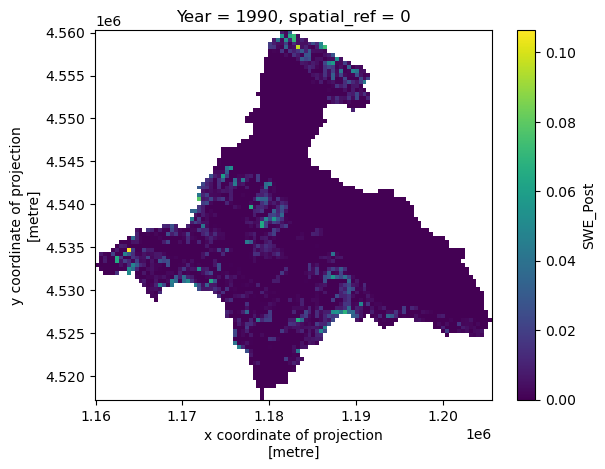

In [376]:
temp_swe.SWE_Post.isel(Year=0).plot()

In [421]:
year = 1990

temp_swe = swe_utm.where(temp_swe.SWE_Post.mean(dim='Year')>0.1).rio.clip(huc10[0:1].geometry)
swe_calc = station_gdf.loc[pd.IndexSlice[huc10.loc[0,'nearest_loc'],year],'station_snv'] * temp_swe.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(temp_swe.SWE_Post.mean(dim='Year')>0.1) + temp_swe.SWE_Post.mean(dim='Year').where(temp_swe.SWE_Post.mean(dim='Year')>0.1)
#huc10_swe.loc[pd.IndexSlice[huc10.loc[0, 'name'],year],'swe_reanalysis_sum'] = np.nansum(temp_swe.SWE_Post[year-1990].values)
#huc10_swe.loc[pd.IndexSlice[huc10.loc[0, 'name'],year],'swe_snv_sum'] = np.nansum(swe_calc.values)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [411]:
temp_swe = swe_utm.rio.clip(huc10[0:1].geometry)

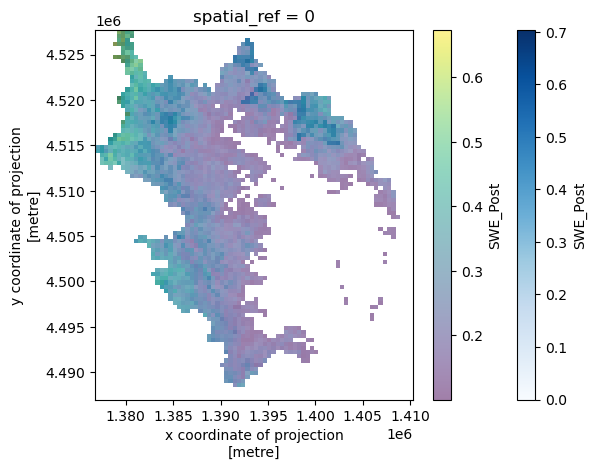

In [422]:
fig, ax = plt.subplots()
temp_swe.SWE_Post[0].plot(ax=ax,cmap='Blues')
swe_calc.plot(ax=ax, alpha=0.5)

<Axes: title={'center': 'Year = 2021, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

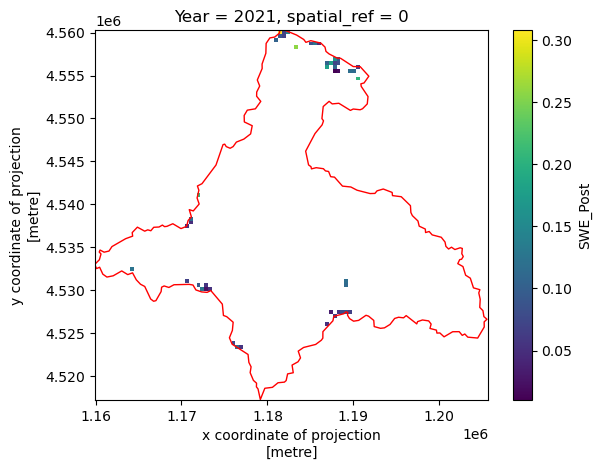

In [457]:
fig, ax = plt.subplots()
temp_swe.SWE_Post[31].where(temp_swe.SWE_Post.mean(dim='Year')>0.1).plot()
huc10[huc10['name']=='Conway Draw-Green River'].plot(ax=ax, facecolor='none', edgecolor='red')

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

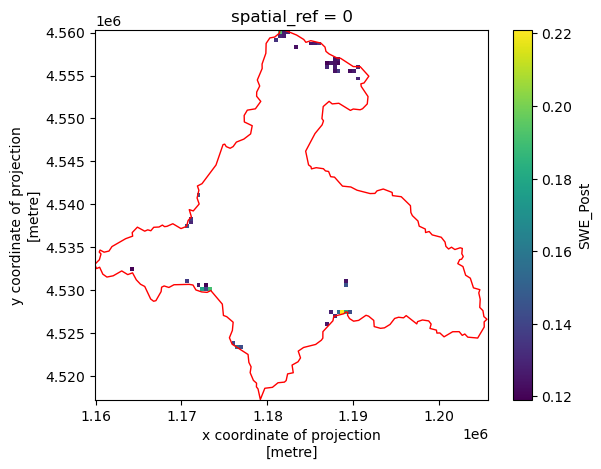

In [455]:
fig, ax = plt.subplots()
swe_calc_temp.plot(ax=ax)
huc10[huc10['name']=='Conway Draw-Green River'].plot(ax=ax, facecolor='none', edgecolor='red')

<Axes: title={'center': 'Year = 2021, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

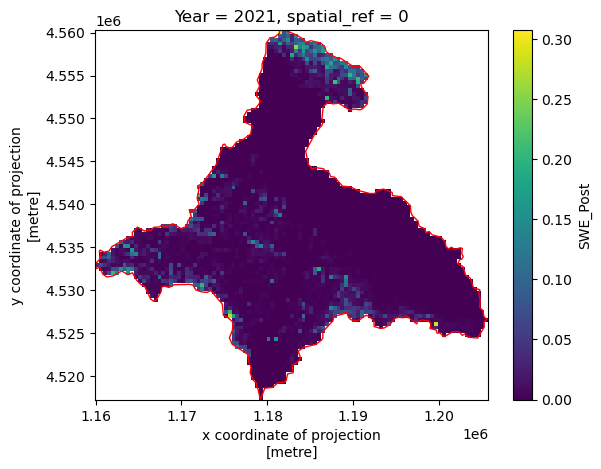

In [454]:
fig, ax = plt.subplots()
temp_swe.SWE_Post[31].plot(ax=ax)
huc10[huc10['name']=='Conway Draw-Green River'].plot(ax=ax, facecolor='none', edgecolor='red')

### Run through time, then by watershed:

### Do the first watershed:

### Loop through all watersheds and years, and append watersheds together:

In [74]:
# Run for one watershed in one year first:
year = 1990

# clip the swe reanalysis data to the watershed geometry:
watershed_reanalysis = swe_utm.rio.clip(huc10[0:1].geometry)

# Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
swe_calc = huc10_swe.loc[1401000107, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)

# Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
huc10_swe.loc[1401000107, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
huc10_swe.loc[1401000107, year]['swe_snv_sum'] = np.nansum(swe_calc.values)

# Iterate over all the years of swe reanalysis data:
for year in range(1991,2022):
    # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
    swe_calc_temp = huc10_swe.loc[1401000107, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
    
    # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
    huc10_swe.loc[1401000107, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
    huc10_swe.loc[1401000107, year]['swe_snv_sum'] = np.nansum(swe_calc_temp.values)

    swe_calc = xr.concat([swe_calc, swe_calc_temp], "Year")



for id in huc10.index[1:]:
    
    # Run for one watershed in one year first:
    year = 1990

    # clip the swe reanalysis data to the watershed geometry:
    watershed_reanalysis = swe_utm.rio.clip([huc10.loc[id].geometry])
    
    # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
    swe_calc_2 = huc10_swe.loc[id, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
    
    # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
    huc10_swe.loc[id, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
    huc10_swe.loc[id, year]['swe_snv_sum'] = np.nansum(swe_calc_2.values)
    
    # Iterate over all the years of swe reanalysis data:
    for year in range(1991,2022):
        # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
        swe_calc_temp = huc10_swe.loc[id, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
        
        # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
        huc10_swe.loc[id, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
        huc10_swe.loc[id, year]['swe_snv_sum'] = np.nansum(swe_calc_temp.values)
    
        swe_calc_2 = xr.concat([swe_calc_2, swe_calc_temp], "Year")
    
    swe_calc_aligned, swe_calc_2_aligned = xr.align(swe_calc, swe_calc_2, join='outer')
    combined_data = xr.where(swe_calc_aligned.isnull(), swe_calc_2_aligned, swe_calc_aligned)
    combined_data = xr.where(swe_calc_2_aligned.isnull(), swe_calc_aligned, combined_data)
    combined_data = xr.where((~swe_calc_aligned.isnull()) & (~swe_calc_2_aligned.isnull()),
                         (swe_calc_aligned + swe_calc_2_aligned) / 2, combined_data)
    swe_calc = combined_data

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of f

In [123]:
huc10_swe['name'] = ''
for id in huc10_swe.index.get_level_values(0):
    huc10_swe.loc[id, 'name'] = huc10.loc[id]['name']

In [84]:
swe_calc.to_netcdf('../data/swe_calculated_snv.nc')

In [208]:
huc10_swe.to_csv('../data/swe_totals_ucrb.csv')

In [12]:
swe_calc = xr.open_dataarray('../data/swe_calculated_snv.nc')
huc10_swe = gpd.read_file('../data/swe_totals_ucrb.csv')

### Run for years without SWE Reanalysis:

In [15]:
idx = pd.MultiIndex.from_product([huc10.huc10.unique(),
                                  range(2022,2025)],
                                 names=['huc10_id', 'year'])

col = ['swe_snv_sum','swe_reanalysis_sum','snv_snotel']
huc10_swe_nore = pd.DataFrame(np.nan, idx, col)

In [16]:
huc10_swe_nore

swe_snv_sum  swe_reanalysis_sum  snv_snotel
huc10_id   year                                             
1401000107 2022          NaN                 NaN         NaN
           2023          NaN                 NaN         NaN
           2024          NaN                 NaN         NaN
1401000110 2022          NaN                 NaN         NaN
           2023          NaN                 NaN         NaN
...                      ...                 ...         ...
1405000307 2023          NaN                 NaN         NaN
           2024          NaN                 NaN         NaN
1404010610 2022          NaN                 NaN         NaN
           2023          NaN                 NaN         NaN
           2024          NaN                 NaN         NaN

[906 rows x 3 columns]

In [18]:
station_gdf

station_snv  station_swe                     geometry
station     year                                                       
301_CA_SNTL 1990    -0.492262     0.193040  POINT (-120.79192 41.23583)
            1991    -0.806681     0.142240  POINT (-120.79192 41.23583)
            1992    -1.639892     0.007620  POINT (-120.79192 41.23583)
            1993     0.938344     0.424180  POINT (-120.79192 41.23583)
            1994    -0.335053     0.218440  POINT (-120.79192 41.23583)
...                       ...          ...                          ...
BLD         2017     0.619445     1.033272  POINT (-120.03488 38.45126)
            2018    -0.806206     0.371856  POINT (-120.03488 38.45126)
            2019     0.501188     0.978408  POINT (-120.03488 38.45126)
            2020    -0.615681     0.460248  POINT (-120.03488 38.45126)
            2021    -0.418586     0.551688  POINT (-120.03488 38.45126)

[14240 rows x 3 columns]

In [20]:
import pickle

In [22]:
station_swe = pickle.load(open('../../../../Research/CorrelatedDomains/data/combined_snotel_cdec/combined_april1_swe.pkl', 'rb'))

In [23]:
station_swe

301_CA_SNTL  302_OR_SNTL  303_CO_SNTL  304_OR_SNTL  \
1990-04-01 00:00:00+00:00      0.19304      0.57150      0.05842      0.25400   
1991-04-01 00:00:00+00:00      0.14224      0.54102      0.13716      0.33528   
1992-04-01 00:00:00+00:00      0.00762      0.43180      0.24638      0.03302   
1993-04-01 00:00:00+00:00      0.42418      0.65278      0.37338      0.67310   
1994-04-01 00:00:00+00:00      0.21844      0.58420      0.14478      0.40894   
1995-04-01 00:00:00+00:00      0.58166      0.89408      0.09398      0.58674   
1996-04-01 00:00:00+00:00      0.38100      0.62738      0.02794      0.47244   
1997-04-01 00:00:00+00:00      0.21590      1.04140      0.00254      0.49276   
1998-04-01 00:00:00+00:00      0.52578      0.60960      0.21844      0.56388   
1999-04-01 00:00:00+00:00      0.51054      0.87884      0.00000      0.73914   
2000-04-01 00:00:00+00:00      0.29464      0.65024      0.22098      0.39878   
2001-04-01 00:00:00+00:00      0.10160      0.33528      0.09652      0.31496   
2002-04-01 00:00:00+00:00      0.29464      0.65532      0.00508      0.40386   
2003-04-01 00:00:00+00:00      0.08128      0.55372      0.18034      0.34290   
2004-04-01 00:00:00+00:00      0.22606      0.56134      0.00000      0.44958   
2005-04-01 00:00:00+00:00      0.26924      0.36322      0.35306      0.23876   
2006-04-01 00:00:00+00:00      0.37084      0.75946      0.05334      0.59944   
2007-04-01 00:00:00+00:00      0.11684      0.37846      0.15494      0.27432   
2008-04-01 00:00:00+00:00      0.33528      0.68580      0.34798      0.49022   
2009-04-01 00:00:00+00:00      0.27940      0.48006      0.09144      0.51054   
2010-04-01 00:00:00+00:00      0.33782      0.42418      0.24384      0.37846   
2011-04-01 00:00:00+00:00      0.47498      0.56388      0.02540      0.46990   
2012-04-01 00:00:00+00:00      0.17272      0.60198      0.13462      0.37084   
2013-04-01 00:00:00+00:00      0.03302      0.51054      0.03810      0.35306   
2014-04-01 00:00:00+00:00      0.09144      0.61214      0.00000      0.24638   
2015-04-01 00:00:00+00:00      0.00000      0.34798      0.00000      0.05080   
2016-04-01 00:00:00+00:00      0.40386      0.63754      0.01270      0.46228   
2017-04-01 00:00:00+00:00      0.48260      0.68834      0.17526      0.50546   
2018-04-01 00:00:00+00:00      0.14732      0.44958      0.00000      0.29972   
2019-04-01 00:00:00+00:00      0.54356      0.51816      0.29464      0.46228   
2020-04-01 00:00:00+00:00      0.18542      0.44704      0.05842      0.43942   
2021-04-01 00:00:00+00:00      0.27940      0.42672      0.19050      0.49784   

                           306_ID_SNTL  308_AZ_SNTL  309_WY_SNTL  310_AZ_SNTL  \
1990-04-01 00:00:00+00:00      0.50038      0.00000      0.64008      0.00000   
1991-04-01 00:00:00+00:00      0.51054      0.26670      0.48768      0.31750   
1992-04-01 00:00:00+00:00      0.45720      0.21844      0.36576      0.21844   
1993-04-01 00:00:00+00:00      0.84328      0.09398      0.38862      0.36322   
1994-04-01 00:00:00+00:00      0.48006      0.00254      0.57912      0.05588   
1995-04-01 00:00:00+00:00      0.98298      0.00000      0.42926      0.09906   
1996-04-01 00:00:00+00:00      0.94742      0.00000      0.55118      0.00254   
1997-04-01 00:00:00+00:00      1.17602      0.00000      0.56642      0.05080   
1998-04-01 00:00:00+00:00      0.72136      0.29972      0.47752      0.27432   
1999-04-01 00:00:00+00:00      0.99314      0.00000      0.50038      0.00000   
2000-04-01 00:00:00+00:00      0.70358      0.00254      0.49784      0.00000   
2001-04-01 00:00:00+00:00      0.39624      0.00508      0.36322      0.16256   
2002-04-01 00:00:00+00:00      0.69596      0.00000      0.40132      0.00000   
2003-04-01 00:00:00+00:00      0.75946      0.00000      0.49276      0.18796   
2004-04-01 00:00:00+00:00      0.59690      0.00000      0.43434      0.00000   
2005-04-01 00:00:00+00:00      0.50546      0.07620      

In [ ]:
for name in station_swe.columns.values:
    for year in station_swe.index.values:
        df.loc[(name,year),'station_n'] = (station_swe[name][year] - station_mean_sdev['mean_swe'][name]) / station_mean_sdev['stdev'][name]

In [ ]:
for id, yr in zip(huc10_swe_nore.index.get_level_values(0), huc10_swe_nore.index.get_level_values(1)):
    huc10_swe_nore.loc[id,yr]['snv_snotel'] = station_gdf.loc[huc10.loc[id]['nearest_loc'],yr]['station_snv']

In [ ]:
# Run for one watershed in one year first:
year = 2022

# clip the swe reanalysis data to the watershed geometry:
watershed_reanalysis = swe_utm.rio.clip(huc10[0:1].geometry)

# Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
swe_calc_nore = huc10_swe.loc[1401000107, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)

# Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
#huc10_swe.loc[1401000107, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
huc10_swe.loc[1401000107, year]['swe_snv_sum'] = np.nansum(swe_calc_nore.values)

# Iterate over all the years of swe reanalysis data:
for year in [2023, 2024]:
    # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
    swe_calc_temp = huc10_swe.loc[1401000107, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
    
    # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
    huc10_swe.loc[1401000107, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
    huc10_swe.loc[1401000107, year]['swe_snv_sum'] = np.nansum(swe_calc_temp.values)

    swe_calc = xr.concat([swe_calc, swe_calc_temp], "Year")



for id in huc10.index[1:]:
    
    # Run for one watershed in one year first:
    year = 1990

    # clip the swe reanalysis data to the watershed geometry:
    watershed_reanalysis = swe_utm.rio.clip([huc10.loc[id].geometry])
    
    # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
    swe_calc_2 = huc10_swe.loc[id, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
    
    # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
    huc10_swe.loc[id, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
    huc10_swe.loc[id, year]['swe_snv_sum'] = np.nansum(swe_calc_2.values)
    
    # Iterate over all the years of swe reanalysis data:
    for year in range(1991,2022):
        # Create a new data array of calculated swe from the standard normal variate and the long-term swe reanalysis statistics:
        swe_calc_temp = huc10_swe.loc[id, year]['snv_snotel'] * watershed_reanalysis.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1) + watershed_reanalysis.SWE_Post.mean(dim='Year').where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1)
        
        # Populate the dataframe with total swe in the watershed from reanalysis and snv swe:
        huc10_swe.loc[id, year]['swe_reanalysis_sum'] = np.nansum(watershed_reanalysis.SWE_Post[year-1990].where(watershed_reanalysis.SWE_Post.mean(dim='Year')>0.1).values)
        huc10_swe.loc[id, year]['swe_snv_sum'] = np.nansum(swe_calc_temp.values)
    
        swe_calc_2 = xr.concat([swe_calc_2, swe_calc_temp], "Year")
    
    swe_calc_aligned, swe_calc_2_aligned = xr.align(swe_calc, swe_calc_2, join='outer')
    combined_data = xr.where(swe_calc_aligned.isnull(), swe_calc_2_aligned, swe_calc_aligned)
    combined_data = xr.where(swe_calc_2_aligned.isnull(), swe_calc_aligned, combined_data)
    combined_data = xr.where((~swe_calc_aligned.isnull()) & (~swe_calc_2_aligned.isnull()),
                         (swe_calc_aligned + swe_calc_2_aligned) / 2, combined_data)
    swe_calc = combined_data

In [199]:
area_pixel = (swe_calc.x[1] - swe_calc.x[0]) * (swe_calc.y[1] - swe_calc.y[0])

In [202]:
area_pixel.values

array(204874.55664814)

In [204]:
huc10_swe['swe_snv_sum_m3'] = huc10_swe['swe_snv_sum'] * area_pixel.values

In [206]:
huc10_swe['swe_reanalysis_sum_m3'] = huc10_swe['swe_reanalysis_sum'] * area_pixel.values

In [207]:
huc10_swe

swe_snv_sum  swe_reanalysis_sum  snv_snotel  \
huc10_id   year                                                
1401000107 1990   540.767822          390.051422    0.008432   
           1991   629.325073          434.512390    0.325875   
           1992   297.235443          442.974609   -0.864536   
           1993   607.185730          711.315186    0.246514   
           1994   381.364807          403.953003   -0.562965   
...                      ...                 ...         ...   
1404010610 2017     8.141639            7.115200    0.504671   
           2018     6.198155            0.412800    0.137638   
           2019     4.532314            9.636200   -0.176963   
           2020    18.414333            9.251200    2.444706   
           2021    10.085121            4.700800    0.871705   

                                    name  swe_snv_sum_m3  \
huc10_id   year                                            
1401000107 1990              Muddy Creek    1.107896e+08   
           1991              Muddy Creek    1.289327e+08   
           1992              Muddy Creek    6.089598e+07   
           1993              Muddy Creek    1.243969e+08   
           1994              Muddy Creek    7.813195e+07   
...                                  ...             ...   
1404010610 2017  Conway Draw-Green River    1.668015e+06   
           2018  Conway Draw-Green River    1.269844e+06   
           2019  Conway Draw-Green River    9.285558e+05   
           2020  Conway Draw-Green River    3.772628e+06   
           2021  Conway Draw-Green River    2.066185e+06   

                 swe_reanalysis_sum_m3  
huc10_id   year                         
1401000107 1990           7.991161e+07  
           1991           8.902053e+07  
           1992           9.075423e+07  
           1993           1.457304e+08  
           1994           8.275969e+07  
...                                ...  
1404010610 2017           1.457723e+06  
           2018           8.457222e+04  
           2019           1.974212e+06  
           2020           1.895335e+06  
           2021           9.630743e+05  

[9664 rows x 6 columns]

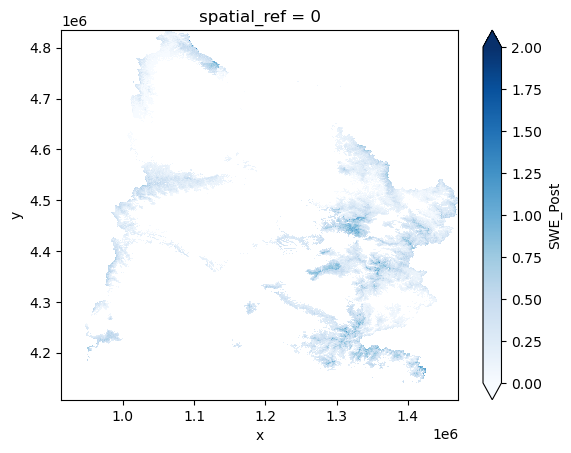

In [125]:
swe_calc[2].plot(cmap='Blues',vmin=0,vmax=2)

In [111]:
huc10_swe

swe_snv_sum  swe_reanalysis_sum  snv_snotel name
huc10_id   year                                                  
1401000107 1990   540.767822          390.051422    0.008432     
           1991   629.325073          434.512390    0.325875     
           1992   297.235443          442.974609   -0.864536     
           1993   607.185730          711.315186    0.246514     
           1994   381.364807          403.953003   -0.562965     
...                      ...                 ...         ...  ...
1404010610 2017     8.141639            7.115200    0.504671     
           2018     6.198155            0.412800    0.137638     
           2019     4.532314            9.636200   -0.176963     
           2020    18.414333            9.251200    2.444706     
           2021    10.085121            4.700800    0.871705     

[9664 rows x 4 columns]

In [124]:
huc10_swe

swe_snv_sum  swe_reanalysis_sum  snv_snotel  \
huc10_id   year                                                
1401000107 1990   540.767822          390.051422    0.008432   
           1991   629.325073          434.512390    0.325875   
           1992   297.235443          442.974609   -0.864536   
           1993   607.185730          711.315186    0.246514   
           1994   381.364807          403.953003   -0.562965   
...                      ...                 ...         ...   
1404010610 2017     8.141639            7.115200    0.504671   
           2018     6.198155            0.412800    0.137638   
           2019     4.532314            9.636200   -0.176963   
           2020    18.414333            9.251200    2.444706   
           2021    10.085121            4.700800    0.871705   

                                    name  
huc10_id   year                           
1401000107 1990              Muddy Creek  
           1991              Muddy Creek  
           1992              Muddy Creek  
           1993              Muddy Creek  
           1994              Muddy Creek  
...                                  ...  
1404010610 2017  Conway Draw-Green River  
           2018  Conway Draw-Green River  
           2019  Conway Draw-Green River  
           2020  Conway Draw-Green River  
           2021  Conway Draw-Green River  

[9664 rows x 4 columns]

<Axes: xlabel='year'>

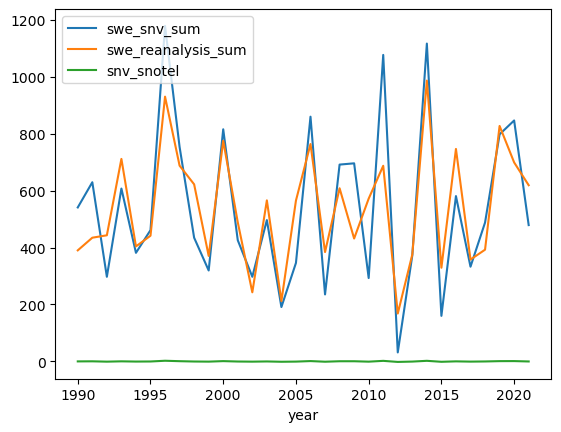

In [80]:
huc10_swe.loc[1401000107].plot()

### Calculate comparison statistics to SWE Reanalysis:

In [142]:
import regionmask

In [146]:
huc10_4326 = huc10.to_crs('epsg:4326')

In [149]:
huc10_4326[0:1]

huc2  areaacres  areasqkm states         name  cluster  \
huc10                                                                
1401000107    14  188277.05    761.93     CO  Muddy Creek      1.0   

            area_cluster  nearest_loc  \
huc10                                   
1401000107  6.118408e+08  408_CO_SNTL   

                                                     geometry  
huc10                                                          
1401000107  POLYGON ((-106.63836 40.43243, -106.63234 40.4...

In [152]:
swe

<xarray.Dataset>
Dimensions:      (y: 1776, x: 1508, Year: 32)
Coordinates:
  * y            (y) float64 35.56 35.57 35.57 35.58 ... 43.44 43.44 43.45 43.45
  * x            (x) float64 -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 ...
Data variables:
    SWE_Post     (Year, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [153]:
swe_rename = swe.rename({'x':'lon', 'y':'lat'})
#da.rename({'x': 'lon', 'y': 'lat'})

In [154]:
swe_rename

<xarray.Dataset>
Dimensions:      (lat: 1776, lon: 1508, Year: 32)
Coordinates:
  * lat          (lat) float64 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * lon          (lon) float64 -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 ...
Data variables:
    SWE_Post     (Year, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [ ]:
# Calculate statistics: 
ds_clip = ds.rio.clip(aso_poly.to_crs('epsg:4326').geometry)
aso_match = aso.rio.reproject_match(ds_clip, resampling = rio.enums.Resampling.cubic)

r = np.corrcoef(aso_match.values[ds_clip.notnull() & aso_match.notnull()].flatten(), ds_clip.values[ds_clip.notnull() & aso_match.notnull()])[0,1]
md = dif.values[dif.notnull()].mean()
rmse = np.sqrt(((ds_clip.values[ds_clip.notnull()] - aso_match.values[ds_clip.notnull()].flatten()) ** 2).mean())
print('R = ', r)
print('MD = ', md)
print('RMSE = ', rmse)

In [168]:
mask = regionmask.mask_3D_geopandas(huc10_4326[0:1], swe_rename.SWE_Post)

In [172]:
masked_da = swe_rename.SWE_Post[1].where(mask)

In [173]:
mean_value = masked_da.mean().values

In [174]:
mean_value

array(0.152172, dtype=float32)

In [176]:
swe_calc_4326 = swe_calc.rio.reproject('epsg:4326').rename({'x':'lon', 'y':'lat'})

In [182]:
swe_rename

<xarray.Dataset>
Dimensions:      (lat: 1776, lon: 1508, Year: 32)
Coordinates:
  * lat          (lat) float64 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * lon          (lon) float64 -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0
Data variables:
    SWE_Post     (Year, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [180]:
dif_re_calc_4326 = swe_rename.SWE_Post - swe_calc_4326

In [181]:
dif_re_calc_4326

<xarray.DataArray 'SWE_Post' (Year: 32, lat: 0, lon: 0)>
array([], shape=(32, 0, 0), dtype=float32)
Coordinates:
  * lat          (lat) float64 
  * lon          (lon) float64 
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0

In [ ]:
mask = regionmask.mask_3D_geopandas(huc10_4326[0:1], swe_rename.SWE_Post)
masked_da = swe_rename.SWE_Post[1].where(mask)
masked_da_calc = swe_calc_4326[1].where(mask)

r = np.corrcoef(masked_da.values[masked_da_calc.notnull() & masked_da.notnull()].flatten(), masked_da_calc.values[masked_da_calc.notnull() & masked_da.notnull()])[0,1]
md = dif.values[dif.notnull()].mean()
rmse = np.sqrt(((ds_clip.values[ds_clip.notnull()] - aso_match.values[ds_clip.notnull()].flatten()) ** 2).mean())

In [147]:
# Create a mask for your polygon
mask = regionmask.mask_geopandas(huc10_4326, swe.SWE_Post[0])

# Apply the mask to your DataArray
masked_da = swe.SWE_Post[0].where(mask)

# Compute statistics within the masked region
mean_value = masked_da.mean().values
sum_value = masked_da.sum().values

type: 'Could not get ``lon`` from ``lon_or_obj``. Please pass lon and lat directlyor try installing cf_xarray.'

In [143]:
swe_utm

<xarray.Dataset>
Dimensions:      (x: 1447, y: 2053, Year: 32)
Coordinates:
  * x            (x) float64 8.782e+05 8.787e+05 ... 1.532e+06 1.533e+06
  * y            (y) float64 4.874e+06 4.874e+06 ... 3.946e+06 3.945e+06
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0
Data variables:
    SWE_Post     (Year, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [135]:
from rasterstats import zonal_stats

In [139]:
swe_utm.rio.crs

CRS.from_epsg(32611)

In [140]:
zonal_stats?

Signature: zonal_stats(*args, **kwargs)
Docstring:
The primary zonal statistics entry point.

All arguments are passed directly to ``gen_zonal_stats``.
See its docstring for details.

The only difference is that ``zonal_stats`` will
return a list rather than a generator.
File:      ~/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterstats/main.py
Type:      function

In [136]:
swe_zonal = zonal_stats(
    vectors = huc10.geometry,
    raster = swe_utm.SWE_Post[0].values,
    affine=swe_utm.rio.transform(),
    stats=['sum'],
    nodata = -9999
)

In [137]:
swe_zonal

[{'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum': None},
 {'sum':

In [ ]:
nbr_zonal = zonal_stats(
    vectors=polys,
    raster=nbr_mosaic[0,:,:].values, # since it's a 3D array
    affine=nbr_mosaic.rio.transform(),
    stats=["sum"],
)

<Axes: xlabel='year'>

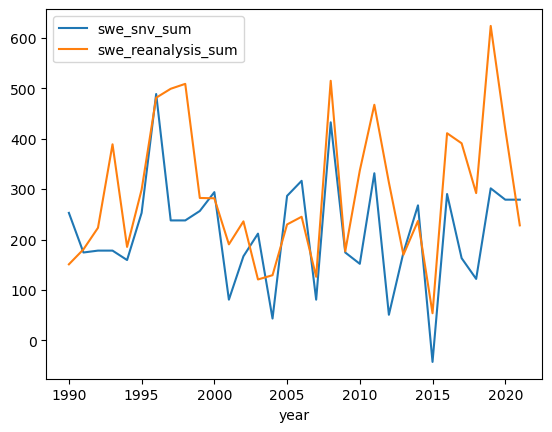

In [368]:
huc10_swe.loc['Muddy Creek'].plot()

In [28]:
swe_calc = swe_calc.rio.set_crs('epsg:32611')

In [8]:
calc_rean_dif = swe_calc - swe_utm

type: name 'swe_utm' is not defined

In [38]:
calc_rean_dif_4326 = calc_rean_dif.rio.reproject('epsg:4326')

In [39]:
calc_rean_dif_4326.to_netcdf('../data/swe_difference_snv_reanalysis.nc')

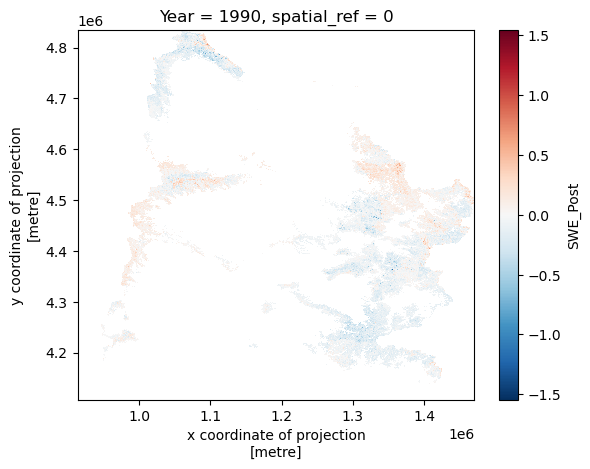

In [36]:
calc_rean_dif.SWE_Post[0].plot()

In [7]:
calc_rean_dif

type: name 'calc_rean_dif' is not defined

In [25]:
calc_rean_dif_4326 = swe_calc - swe.SWE_Post

type: Cannot apply_along_axis when any iteration dimensions are 0

In [128]:
calc_rean_dif

<xarray.Dataset>
Dimensions:      (x: 1230, y: 1606, Year: 32)
Coordinates:
  * x            (x) float64 9.14e+05 9.144e+05 9.149e+05 ... 1.47e+06 1.47e+06
  * y            (y) float64 4.834e+06 4.834e+06 ... 4.108e+06 4.108e+06
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0
Data variables:
    SWE_Post     (Year, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [ ]:
np.nansum(calc_rean_dif

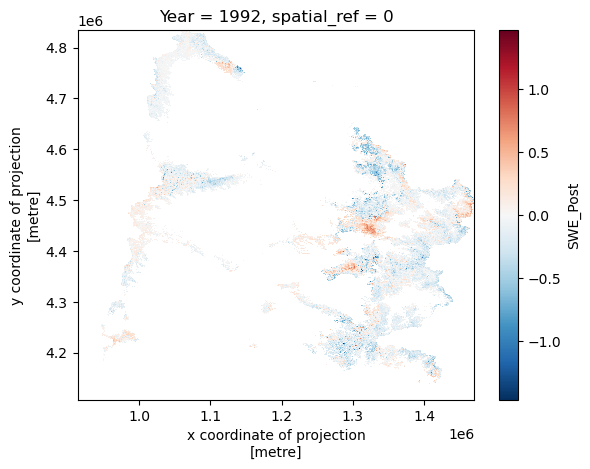

In [131]:
calc_rean_dif.SWE_Post[2].plot()

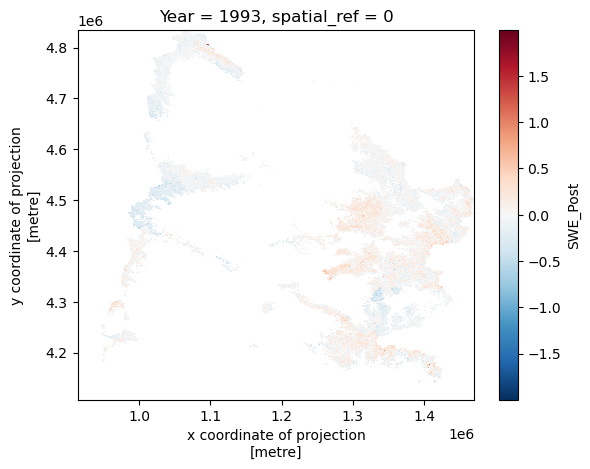

In [132]:
calc_rean_dif.SWE_Post[3].plot()

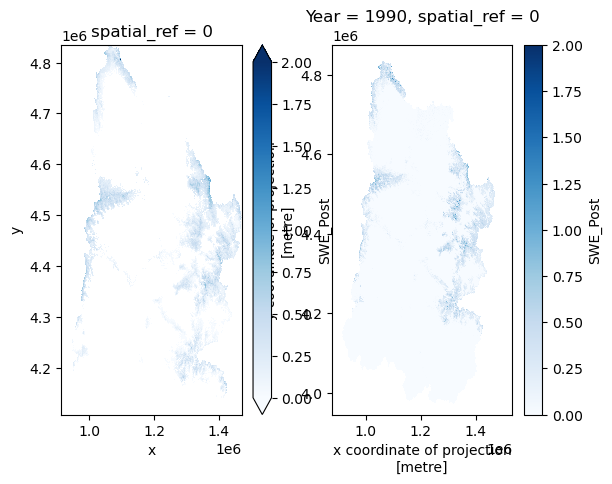

In [311]:
fig, ax = plt.subplots(1,2)
swe_calc.plot(ax=ax[0], cmap='Blues',vmin=0, vmax=2)
swe_utm.SWE_Post[0].plot(ax=ax[1], cmap='Blues',vmin=0, vmax=2)